In [ ]:
######
# Importing the libraries
# They will be described/commented later

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import time
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin # useful for implementing text preprocessing components that can be pipelined
import nltk # nltk provides some useful algorithms and data for natural language processing
from IPython.display import IFrame # to get a better output on Notebooks
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [ ]:
####################################
# Function to load the dataset
dfRaw = None

def loadDataFrame():
  # The next UEL allows us to download the gsheetdata as a .csv file
  # Please, check it out the last part of the url: ?tqx=out:csv&gid=1
  # ...out:csv is a request for csv data, gid=1 is a request for the first sheet
  #urlCsv = "https://docs.google.com/spreadsheets/d/1X6zJNKMWgBsu-Zhe1H3x9smHEz2ft2IZRE0QqTlhDZU/gviz/tq?tqx=out:csv&gid=1"

  url = 'https://drive.google.com/file/d/1A3uBbWtXKFYEnBu18ngOgNPCnqIjOpX3/view?usp=share_link'
  path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
  # To get more info on pandas read_csv(), please refer to
  # https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
  df = pd.read_csv(path,
              quoting=0,  # Quoting=0 removes fields surrounding quotes
              header=0,           # column names are in the first row (i.e., row 0)

                     )
  return df


dfRaw = loadDataFrame()

dfRaw.head()

,Index,text,y
0,6565,Methods \n \n Trial design and s...,1
1,28256,Ethics and Study Design \n The lactofe...,1
2,13877,Study Design \n This study was a prosp...,1
3,24481,Study design and participants \n This ...,1
4,15211,Methods \n \n Trial design \n ...,1


# Esploro il dataset

In [ ]:
##########################
# Let's get some info about the dataframe
# Showing the number of rows and columns of the DataFrame (i.e., of the data matrix)
print(' dfraw.shape i.e., (num. of rows, num. of columns)')
# .shape returns a tuple (# of lines, # of columns)
print(dfRaw.shape) #
print() # print an empty line

# \n is carriage return, "a capo" in Italian
print("\n Number of columns: ")
print(dfRaw.shape[1])
print() # print an empty line

print(' Column names')
# columns are turned into a list to get a cleaner output
print(list(dfRaw.columns))

 dfraw.shape i.e., (num. of rows, num. of columns)
(267, 3)


 Number of columns: 
3

 Column names
['Index', 'text', 'y']


# Data Quality

In [ ]:
######
# Looking for missing values i.e., null values (in pandas they are called NaN)
missingValueMask = dfRaw.isnull().any(axis = 1)
print('Rows with missing values')
# display is like print, it works only in notebooks and
# provide a nice output
display(dfRaw.loc[missingValueMask,:])
print()

print('dfRaw.loc[missingValueMask,:].shape')
print(dfRaw.loc[missingValueMask,:].shape)

Rows with missing values


,Index,text,y



dfRaw.loc[missingValueMask,:].shape
(0, 3)


In [ ]:
######
# Removing missing values, if any
print('Shape before removing missing values', dfRaw.shape)
df = dfRaw.dropna()
print('Shape after', df.shape)
print()

#removing rows with label different than (1,2,3,4)
print('Removing undesired labels')
print('df.shape', df.shape)
permittedLabels=[0,1]
#Below, .isin() works well also when df2.CategoryID has float values
#while permittedLabels has int elements
df2=df.loc[df.loc[:,'y'].isin(permittedLabels)] #,:
print('df2.shape', df2.shape)
print()

# Evaluating Category Sizes (i.e., label subset size)
print('Cat. sizes')
print(df2.loc[:,'y'].value_counts())


Shape before removing missing values (267, 3)
Shape after (267, 3)

Removing undesired labels
df.shape (267, 3)
df2.shape (267, 3)

Cat. sizes
0    168
1     99
Name: y, dtype: int64


In [ ]:
##########################
# Converting y label to int
# (in case it were saved in a non numeric format)
df2['y'] = df2['y'].astype(int)
print('df2.dtypes') # visualizzo i tipi delle colonne. In pandas, le colonne sono chiamate Series.
print(df2.dtypes)
df2.head()

df2.dtypes
Index     int64
text     object
y         int64
dtype: object


,Index,text,y
0,6565,Methods \n \n Trial design and s...,1
1,28256,Ethics and Study Design \n The lactofe...,1
2,13877,Study Design \n This study was a prosp...,1
3,24481,Study design and participants \n This ...,1
4,15211,Methods \n \n Trial design \n ...,1


# Balancing the dataset

In [ ]:
##########################
# Unfortunately, the dataset is unbalanced
# Balancing by undersammpling
def underSample2Min(df, labelName):
    ''' The dataset is undersampled so that all label groups will have the same size,
        corresponding to the (original) minimal label set.
        The parameter labelName is the DataFrmae column hosting the labels'''

    vc = df.loc[:,labelName].value_counts() # Counting label frequencies
    lab2freq = dict(zip(vc.index.tolist(), vc.values.tolist()))
    #print(lab2freq) # if you want to see lab2freq, please uncomment this command
    #print(min(lab2freq.values()))
    minfreq = min(lab2freq.values())
    #print(minfreq)
    idxSample=[]
    for selectedLabel, actualFreq in lab2freq.items():
        selIndexes=df.loc[df.loc[:,labelName]==selectedLabel, :].sample(n=minfreq, random_state = 42).index.tolist()
        idxSample+=selIndexes
    idxSample.sort()
    #print(type(idxSample), idxSample)
    #print(list(df.index)[:5])

    df2 = df.loc[idxSample, :]
    #print(len(idxSample), df2.shape);exit()
    df2 = df2.reset_index() # otherwise missing index may cause problem
    return df2

df3 = underSample2Min(df2, 'y')

# Let's look again to the category sizes
print('Cat. sizes')
print(df3.loc[:,'y'].value_counts())

Cat. sizes
1    99
0    99
Name: y, dtype: int64


# Text Processing and Machine Learning

##Classi per gestire i Text

In [ ]:
########################
# Let's customize (and improve) the preprocessing

# seguono delle classi per implementare gestire dei testi

class BaseWrapper(BaseEstimator, TransformerMixin):
    """class wrapping a sentence processing function so that it can be used in a sklearn.pipeline.Pipeline"""

    def fit(self, x, y=None): #This method is usually overridden in children classes
        """ This method actually does nothing.
        It will be overridden by the child classes.
        In its children implementations this method will perform all the
        setup activities required before calling either the method transform()
        or the method predict().
        E.g., a machine learning classifier is trained calling the fit() method,
        once trained it can be used to classify new elements by calling the method predict()
        """
        return self

    def manageSentence(self, sentence): #This method is usually overridden in children classes
        """Called by transform(). The sentence is expected to be a either a string or a list of words,
        this method can return either a string or a list of words"""
        return sentence

    def transform(self, listOfSentences):
        """ sentenceList: list of sentences.
        Every sentence can be either a string or a list of words
        Return a list of lists. Each sentence is preprocessed using the manageSentence() method.
        Each child class can override the manageSentence() method to implement a specific preprocessing behavior.
        The list of preprocessed documents is returned."""
        toReturn = []
        for sentence in listOfSentences:
            processedSentence = self.manageSentence(sentence)
            toReturn.append(processedSentence)
        return toReturn
        # using python list comprehension, the above method can be implemented in a single line:
        # return [self.manageSentence(sentence) for sentence in listOfSentences]
        # more details https://towardsdatascience.com/python-basics-list-comprehensions-631278f22c40

class HTMLAccentsReplacer(BaseWrapper):
    def manageSentence(self, sentence):
        """Replace html representations of special letters with the corresponding unicode character.
        E.g.  &agrave with à.
        Args:
           * s(string): the string where the html codes should be replaced  """
        assert type(sentence)==type('') or type(sentence)==type(u''), "HTMLAccentsReplacer Assertion Error" # if the parameter is not the right type, the execution is interrupted. This is useful to catch errors
        # sostituita con la versione seguente piu' completa
        replacemap={u'&Ecirc;': u'\xca', u'&raquo;': u'\xbb', u'&eth;': u'\xf0', u'&divide;': u'\xf7',
                    u'&atilde;': u'\xe3', u'&Aelig;': u'\xc6', u'&frac34;': u'\xbe', u'&nbsp;': u' ',
                    u'&Aumbl;': u'\xc4', u'&Ouml;': u'\xd6', u'&Egrave;': u'\xc8', u'&Icirc;': u'\xce',
                    u'&deg;': u'\xb0', u'&ocirc;': u'\xf4', u'&Ugrave;': u'\xd9', u'&ndash;': u'\u2013',
                    u'&gt;': u'>', u'&Thorn;': u'\xde', u'&aring;': u'\xe5', u'&frac12;': u'\xbd',
                    u'&frac14;': u'\xbc', u'&Aacute;': u'\xc1', u'&szlig;': u'\xdf', u'&trade;': u'\u2122',
                    u'&igrave;': u'\xec', u'&aelig;': u'\xe6', u'&times;': u'\xd7', u'&egrave;': u'\xe8',
                    u'&Atilde;': u'\xc3', u'&Igrave;': u'\xcc', u'&Eth;': u'\xd0', u'&ucirc;': u'\xfb',
                    u'&lsquo;': u'\u2018', u'&agrave;': u'\xe0', u'&thorn;': u'\xfe', u'&Ucirc;': u'\xdb',
                    u'&amp;': u'&', u'&uuml;': u'\xfc', u'&yuml;': u'', u'&ecirc;': u'\xea', u'&laquo;': u'\xab',
                    u'&infin;': u'\u221e', u'&Ograve;': u'\xd2', u'&oslash;': u'\xf8', u'&yacute;': u'\xfd',
                    u'&plusmn;': u'\xb1', u'&icirc;': u'\xee', u'&auml;': u'\xe4', u'&ouml;': u'\xf6',
                    u'&Ccedil;': u'\xc7', u'&euml;': u'\xeb', u'&lt;': u'<', u'&eacute;': u'\xe9',
                    u'&ntilde;': u'\xf1', u'&pound;': u'\xa3', u'&Iuml;': u'\xcf', u'&Eacute;': u'\xc9',
                    u'&Ntilde;': u'\xd1', u'&rsquo;': u'\u2019', u'&euro;': u'\u20ac', u'&rdquo;': u'\u201d',
                    u'&Acirc;': u'\xc2', u'&ccedil;': u'\xe7', u'&Iacute;': u'\xcd', u'&quot;': u'"',
                    u'&Aring;': u'\xc5', u'&Oslash;': u'\xd8', u'&Otilde;': u'\xd5', u'&Uacute;': u'\xda',
                    u'&reg;': u'\xae', u'&Yacute;': u'\xdd', u'&iuml;': u'\xef', u'&ugrave;': u'\xf9',
                    u'&alpha;': u'\u03b1', u'&copy;': u'\xa9', u'&ldquo;': u'\u201c', u'&oacute;': u'\xf3',
                    u'&Euml;': u'\xcb', u'&uacute;': u'\xfa', u'&ograve;': u'\xf2', u'&acirc;': u'\xe2',
                    u'&aacute;': u'\xe1', u'&Agrave;': u'\xc0', u'&Oacute;': u'\xd3', u'&Uuml;': u'\xdc',
                    u'&iacute;': u'\xed', u'&cent;': u'\xa2', u'&Ocirc;': u'\xd4', u'&mdash;': u'\u2014',
                    u'&otilde;': u'\xf5', u'&beta;': u'\u03b2'}
        for before in replacemap:
            after=replacemap[before] # getting the string to be replaced
            sentence=sentence.replace(before, after)
        return sentence

'''
# Required in python2, no more necessary in python3
class Str2Unicode(BaseWrapper):
    def manageSentence(self, sentence):
        """Converts raw strings to unicode, to better manage accented letters, money symbols (e.g., pounds)"""
        #print(type(sentence), sentence) # ****** cancellami
        # if the parameter is not the right type, the execution is interrupted
        assert type(sentence)==type('') or type(sentence)==type(u''), "Str2Unicode Assertion Error"
        if type(sentence)==type(u''): # Now it should work also with python3
            return sentence
        elif type(sentence)==type(''):
            return sentence.decode('utf-8', errors='strict')  # interpret all raw strings into unicode
        else:
            return sentence
'''

class Tokenizer(BaseWrapper):
    def manageSentence(self, sentence):
        """This method turn a single document (i.e., a string)
         into a list of single words (i.e., tokens).
        The parameter "sentence" is expected to be a string,
         this method returns a list of strings whereas each string
        is a tokenized word. This method replaces all the punctuation with spaces.
        Two or more consecuitve spaces are reduced to a single space.
        Then the string is splitted in substring using the spaces as split markers"""

        if sentence==None:
            return[]
        # if the parameter is not the right type, the execution is interrupted
        assert type(sentence)==type('') or type(sentence)==type(u''), "Tokenizer Assertion Error"
        punteggiatura=u'!{}[]?"",;.:-<>|/\\*=+-_% \n\t\r()'+u"'" +u'\u2019'+u'\u2018'
        #\r and \n can be used as "new line"
        # Unicode Character 'RIGHT SINGLE QUOTATION MARK' (U+2019)
        #
        for l in punteggiatura:
           #print(s)
           sentence=sentence.replace(l,u" ") #replacing all punctuation characters with spaces

        # loop untill all double spaces are removed
        while sentence.find(u"  ")!=-1:
            sentence=sentence.replace(u"  ",u" ")  #replacing double spaces with a single one
        return sentence.split(u' ')   #e.g., "a b c d".split(' ')  returns ['a','b','c','d']

class LowerCaseReducer(BaseWrapper):
    def manageSentence(self, sentence):
        """sentence is expected to be a list of words (each item is a string),
        this method returns a list of strings whereas each string is the lower case version of the original word"""
        # preliminary check over the input data type
        assert type(sentence)==type([]), "LowerCaseReducer, Assertion Error"
        # The next line uses a python trick called List Comprehensions.
        # More details about List Comprehension on http://www.pythonforbeginners.com/basics/list-comprehensions-in-python
        return [w.lower() for w in sentence]
        # builds a new list, where each word of the original list is turned into a lower case string


class EnglishStopWordsRemover(BaseWrapper):
    def getStopWords(self):
        """This method returns a list of English stop words. Stop words can be added to the list"""
        return [u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves',
                u'you', u'your', u'yours', u'yourself', u'yourselves',
                u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself',
                u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves',
                u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those',
                u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being',
                u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing',
                u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as',
                u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about',
                u'against', u'between', u'into', u'through', u'during', u'before',
                u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in',
                u'out', u'on', u'off', u'over', u'under', u'again', u'further',
                u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how',
                u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other',
                u'some', u'such', u'no', u'nor', u'not', u'only', u'own', u'same',
                u'so', u'than', u'too', u'very', u's', u't', u'can', u'will', u'just',
                u'don', u'should', u'now', u'd', u'll', u'm', u'o', u're', u've', u'y',
                u'ain', u'aren', u'couldn', u'didn', u'doesn', u'hadn', u'hasn', u'haven', u'isn',
                u'ma', u'mightn', u'mustn', u'needn', u'shan', u'shouldn', u'wasn', u'weren',
                u'won', u'wouldn']

    def manageSentence(self, sentence):
        """sentence is expected to be a list of words (a list where each item is a string containing a single word),
        this method returns the input list where the stop words are removed """
        assert type(sentence)==type([]) , "EnglishStopWordsRemover, Assertion Error"
        stopWords = self.getStopWords()
        return [w for w in sentence if w not in stopWords]

class EnglishStemmer(BaseWrapper):
    def __init__(self):
        """Load the NLTK English stemmer. A stemmer is an algorithm that recues a word
        to its base form  e.g., "books" is reduced to "book",
        'children' is reduced to 'child'. """
        self.st = nltk.stem.SnowballStemmer("english") # loading the NLTK stemmer
    def  manageSentence(self, sentence):
        """sentence is expected to be a list of words (a list where each item is a
        string containing a single word), this method returns a list of stemmed words"""
        assert type(sentence)==type([]), "EnglishStemmer, Assertion Error"
        return [self.st.stem(w) for w in sentence]

# Here it is an examle about stemming
#es = EnglishStemmer()
#wt = Tokenizer()
#res=es.transform(wt.transform(["we are looking for some new cars", "having better performances"]))
#print(res)
# [[u'we', u'are', u'look', u'for', u'some', u'new', u'car'], [u'have', u'better', u'perform']]


class RemoveNumbers(BaseWrapper):
    def manageSentence(self, sentence):
        """Sentence is expected to be a list of words (a list where each item is a string containing a single word),
        this method returns the input list where the numbers are removed. """
        assert type(sentence)==type([]), "RemoveNumbers, Assertion Error"
        return [w for w in sentence if w.isdigit()==False]

class RemoveEmptyWords(BaseWrapper):
    def manageSentence(self, sentence):
        """Sentence is expected to be a list of words (a list where each item is a string containing a single word),
        this method returns the input list where the empty words are removed """
        assert type(sentence)==type([]), "RemoveEmptyWords, Assertion Error"
        return [w for w in sentence if not (w==u'' or w=='')]

# No more required. Useful for previous versions of CountVectorizer
class Bag2Text(BaseWrapper):
    def manageSentence(self, sentence):
        """sentence is expected to be a list of words (a list where each item is a string containing a single word),
        this method returns a single string obtained joining the words and separing them using the space"""
        assert type(sentence)==type([]), "Bag2Text, Assertion Error"
        # Next line builds a string by joining with spaces all the elements of sentence
        return u' '.join(sentence)

def unityFunction(x):
  """This function returns the same object received as input.
  For advanced pythonists: equivalent to lambda x:x """
  return x

##Train Test Split


In [ ]:
######
# Splitting the dataset into train and test

xAll = df3.loc[:,'text'] # Selecting the text column. It will be used as input feature i.e., the x
yAll = df3.loc[:,'y'] # Selecting the y column i.e., the y
print('type(xAll)', type(xAll), 'xAll.shape', xAll.shape)
print('type(yAll)', type(yAll), 'xAll.shape', yAll.shape)
print()

# Suddivido xAll e yAll in due sottoinsiemi, rispettivamente di training e test
xTrainVec, xTestVec, yTrain, yTest = train_test_split(
    xAll, yAll, # the x and y to be partitioned
    test_size=0.30, # the test set size will be 30% of the original dataset,
                    # i.e. trainini size will be 70%
    random_state=0, # random_state is the seed to make random number
                    # generation reproducible (and hence the split into train and test)
    stratify=yAll # stratify: tries to ensure a proportional
                  # distribution of labels among train and test set
)

# Now I want to inspect the shape
varDi = {'xAll':xAll, 'yAll':yAll, 'xTrainVec':xTrainVec, 'xTestVec':xTestVec, 'yTrain':yTrain, 'yTest':yTest}
for varName, var in varDi.items(): # return a list of key-value pairs
  print(varName, var.shape)
# since xAll and xTrainVec are pandas Series (i.e., columns), info about the number of columns is missing because is trivial

# xTrain e' una pandas series (semplificando, una colonna del DataFrame),
# la trasformo in una lista di stringhe
xTrain = list(xTrainVec)
xTest = list(xTestVec)

type(xAll) <class 'pandas.core.series.Series'> xAll.shape (198,)
type(yAll) <class 'pandas.core.series.Series'> xAll.shape (198,)

xAll (198,)
yAll (198,)
xTrainVec (138,)
xTestVec (60,)
yTrain (138,)
yTest (60,)


# Pipeline to process Papers - Logistic Regression

In [ ]:
######
#

# Let's build a pipeline for preprocessing and classifying job vacancy titles
cpLogit = Pipeline([
   #('Str2Unicode', Str2Unicode()), no more required in Python3
   ('HTMLAccentsReplacer', HTMLAccentsReplacer() ),
   ('Tokenizer', Tokenizer() ),
   ('LowerCaseReducer', LowerCaseReducer() ),
   ('StopWordsRemover', EnglishStopWordsRemover() ),
   ('Stemmer', EnglishStemmer() ),
   ('RemoveNumbers', RemoveNumbers() ),
   ('RemoveEmptyWords', RemoveEmptyWords() ),
   #('Bag2Text', Bag2Text() ),
   ('vectorizer', TfidfVectorizer()),
   ('classifier', LogisticRegression() ), # LinearSVC
                           ])

# Collecting all the param values in a single data structure.
# The parameter keyword should be composed as follows: pipelineComponentName + '__' + paramName.
clsfParams = {
   'classifier__C': 0.001,
   'classifier__random_state': 42,
   'vectorizer__preprocessor': unityFunction, # since we provided a customized preprocessing pipeline, we turn off the usual preprocessing pipeline
   'vectorizer__tokenizer': unityFunction, # Same as above.
   'vectorizer__ngram_range': (1,1),
}

cpLogit.set_params(**clsfParams)
cpLogit.fit(xTrain, yTrain)
print("Cross val score")
print(np.mean(cross_val_score(cpLogit, xTrain, yTrain, cv=5)))
yPred=cpLogit.predict(xTest)
print('Classification report')
clasRepSt02Logit = classification_report(yTest,yPred)
print(clasRepSt02Logit)
print('Accuracy')
print(accuracy_score(yTest,yPred))

print("Accuracy Train")
print(accuracy_score(yTrain,cpLogit.predict(xTrain)))


Cross val score
0.7068783068783068
Classification report
              precision    recall  f1-score   support

           0       0.83      0.63      0.72        30
           1       0.70      0.87      0.78        30

    accuracy                           0.75        60
   macro avg       0.76      0.75      0.75        60
weighted avg       0.76      0.75      0.75        60

Accuracy
0.75
Accuracy Train
0.9492753623188406


In [ ]:
display(cpLogit)

Pipeline(steps=[('HTMLAccentsReplacer', HTMLAccentsReplacer()),
                ('Tokenizer', Tokenizer()),
                ('LowerCaseReducer', LowerCaseReducer()),
                ('StopWordsRemover', EnglishStopWordsRemover()),
                ('Stemmer', EnglishStemmer()),
                ('RemoveNumbers', RemoveNumbers()),
                ('RemoveEmptyWords', RemoveEmptyWords()),
                ('vectorizer',
                 TfidfVectorizer(preprocessor=<function unityFunction at 0x7f53bde25630>,
                                 tokenizer=<function unityFunction at 0x7f53bde25630>)),
                ('classifier', LogisticRegression(C=0.001, random_state=42))])

## Implemento GridSearch

In [ ]:
# Setting for each parameter the value space (i.e., the set of values to evaluate)
paramSpace = {
   'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100], # Values for grid search should be enclosed by []
   'classifier__solver': ['liblinear'],
   'classifier__class_weight': [None, 'balanced'], # if the classes were imbalanced, we could try this approach
   'classifier__random_state': [42],
   'vectorizer__preprocessor': [unityFunction], # since we provided a customized preprocessing pipeline,
                                                # we turn off the usual preprocessing pipeline
   'vectorizer__tokenizer': [unityFunction], # Same as above.
   'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],   #
   'vectorizer__max_df': [0.7],  # If a term is in more of the 70% of documents, it is too frequent to be discriminative
   'vectorizer__min_df': [2, 4,7], # Minimum number of documents where the term should appear
                                   # (otherwise it won't be considered in the Vocabulary)
   'vectorizer__norm': ["l1", "l2", None],
   'vectorizer__use_idf': [True, False]

} # a python list [] is mandatory even if only one element is in

In [ ]:
start_time = time.time()
# cv=4 k-fold validation, con k=4
gsLogit = GridSearchCV(cpLogit, param_grid=paramSpace, scoring='accuracy', cv=5, verbose = 10, n_jobs = -1)
gsLogit.fit(xTrain,yTrain)
# ora mostro il tempo di fine
print("--- %s seconds ---" % (time.time() - start_time))
print(gsLogit.best_params_)
print('Scoring result')
print(gsLogit.best_score_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
--- 259.72527503967285 seconds ---
{'classifier__C': 100, 'classifier__class_weight': None, 'classifier__random_state': 42, 'classifier__solver': 'liblinear', 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 7, 'vectorizer__ngram_range': (1, 3), 'vectorizer__norm': 'l2', 'vectorizer__preprocessor': <function unityFunction at 0x7f53bde25630>, 'vectorizer__tokenizer': <function unityFunction at 0x7f53bde25630>, 'vectorizer__use_idf': False}
Scoring result
0.8253968253968254


In [ ]:
print(classification_report(yTest, gsLogit.predict(xTest)))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        30
           1       0.81      0.73      0.77        30

    accuracy                           0.78        60
   macro avg       0.79      0.78      0.78        60
weighted avg       0.79      0.78      0.78        60



In [ ]:
######
#

# Doing classification again, using the best parameters, as selected by Grid Search.
# The params used here might be sligthly different w.r.t to the previous grid search output
cpLogitCV = Pipeline([
   #('Str2Unicode', Str2Unicode()), no more required in Python3
   ('HTMLAccentsReplacer', HTMLAccentsReplacer() ),
   ('Tokenizer', Tokenizer() ),
   ('LowerCaseReducer', LowerCaseReducer() ),
   ('StopWordsRemover', EnglishStopWordsRemover() ),
   ('Stemmer', EnglishStemmer() ),
   ('RemoveNumbers', RemoveNumbers() ),
   ('RemoveEmptyWords', RemoveEmptyWords() ),
   #('Bag2Text', Bag2Text() ),
   ('vectorizer', TfidfVectorizer()),
   ('classifier', LogisticRegression() ), # LinearSVC
                           ])
clsfParams = {
   'classifier__C': 1,
   'classifier__solver': 'liblinear',
   'classifier__random_state': 42,
   'vectorizer__preprocessor': unityFunction, # since we provided a customized preprocessing pipeline, we turn off the usual preprocessing pipeline
   'vectorizer__tokenizer': unityFunction,
   'vectorizer__ngram_range': (1,3),
   'vectorizer__min_df': 4,
   'vectorizer__max_df': 0.7,
   'vectorizer__norm': None,
   'vectorizer__use_idf': False
}
cpLogitCV.set_params(**clsfParams)
cpLogitCV.fit(xTrain, yTrain)
yPred=cpLogitCV.predict(xTest)
print('Classification report')
print(classification_report(yTest,yPred))
print('Accuracy')
print(accuracy_score(yTest,yPred))

print("Accuracy Train")
print(accuracy_score(yTrain,cpLogitCV.predict(xTrain)))

Classification report
              precision    recall  f1-score   support

           0       0.90      0.87      0.88        30
           1       0.87      0.90      0.89        30

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

Accuracy
0.8833333333333333
Accuracy Train
0.9927536231884058


Migliorato. Overfitting?



In [ ]:
from sklearn.model_selection import learning_curve, LearningCurveDisplay
import matplotlib.pyplot as plt

train_size_abs, train_scores, test_scores = learning_curve(cpLogitCV, xAll, yAll, train_sizes=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])




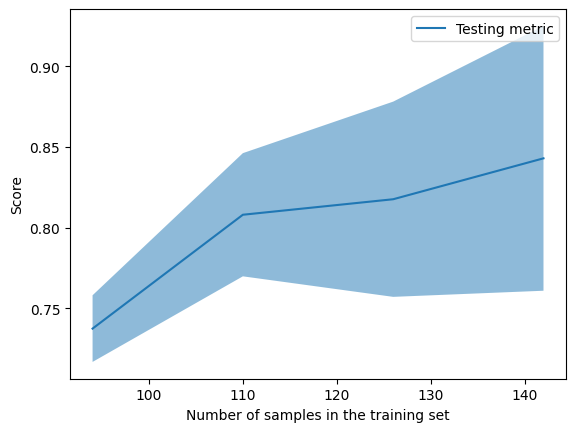

In [ ]:
LearningCurveDisplay.from_estimator(cpLogitCV, xAll, yAll, train_sizes = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
plt.show()


Più osservazioni abbiamo meglio è

## Provo RandomizedSearchCV


In [ ]:

# Setting for each parameter the value space (i.e., the set of values to evaluate)
paramSpace = {
   'classifier__C': loguniform(1e-4, 1e3), # Values for grid search should be enclosed by []
   'classifier__solver': ['liblinear'],
   'classifier__class_weight': [None, 'balanced'], # if the classes were imbalanced, we could try this approach
   'classifier__random_state': [42],
   'vectorizer__preprocessor': [unityFunction], # since we provided a customized preprocessing pipeline, we turn off the usual preprocessing pipeline
   'vectorizer__tokenizer': [unityFunction], # Same as above.
   'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],   #
   'vectorizer__max_df': uniform.rvs(0.5, 0.4, size = 1000, random_state = 42),  # If a term is in more of the 70% of documents, it is too frequent to be discriminative
   'vectorizer__min_df': uniform.rvs(0, 0.3, size = 1000, random_state = 42), # Minimum number of documents where the term should appear (otherwise it won't be considered in the Vocabulary)
   'vectorizer__norm': ["l1", "l2", None],
   'vectorizer__use_idf': [True, False]

} # a python list [] is mandatory even if only one element is in


In [ ]:
start_time = time.time()
# cv=5 k-fold validation, con k=5
gsRndLogit = RandomizedSearchCV(cpLogit, param_distributions=paramSpace, scoring='accuracy', cv=5, verbose = 10, random_state = 42, n_jobs = -1, n_iter=650, error_score = "raise")
gsRndLogit.fit(xTrain,yTrain)
# ora mostro il tempo di fine
print("--- %s seconds ---" % (time.time() - start_time))
print(gsRndLogit.best_params_)
print('Scoring result')
print(gsRndLogit.best_score_)

Fitting 5 folds for each of 650 candidates, totalling 3250 fits
--- 251.90070796012878 seconds ---
{'classifier__C': 30.678058688236316, 'classifier__class_weight': None, 'classifier__random_state': 42, 'classifier__solver': 'liblinear', 'vectorizer__max_df': 0.5180874680424757, 'vectorizer__min_df': 0.24540442977674792, 'vectorizer__ngram_range': (1, 1), 'vectorizer__norm': 'l2', 'vectorizer__preprocessor': <function unityFunction at 0x7f53bde25630>, 'vectorizer__tokenizer': <function unityFunction at 0x7f53bde25630>, 'vectorizer__use_idf': False}
Scoring result
0.8693121693121693


In [ ]:
print(classification_report(yTest, gsRndLogit.predict(xTest)))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        30
           1       0.86      0.80      0.83        30

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60



In [ ]:
######
#

# Doing classification again, using the best parameters, as selected by Grid Search.
# The params used here might be sligthly different w.r.t to the previous grid search output
cpLogitRandCV = Pipeline([
   #('Str2Unicode', Str2Unicode()), no more required in Python3
   ('HTMLAccentsReplacer', HTMLAccentsReplacer() ),
   ('Tokenizer', Tokenizer() ),
   ('LowerCaseReducer', LowerCaseReducer() ),
   ('StopWordsRemover', EnglishStopWordsRemover() ),
   ('Stemmer', EnglishStemmer() ),
   ('RemoveNumbers', RemoveNumbers() ),
   ('RemoveEmptyWords', RemoveEmptyWords() ),
   #('Bag2Text', Bag2Text() ),
   ('vectorizer', TfidfVectorizer()),
   ('classifier', LogisticRegression() ), # LinearSVC
                           ])
clsfParams = {
   'classifier__C': 97.32492732174423,
   'classifier__class_weight': 'balanced',
   'classifier__solver': 'liblinear',
   'classifier__random_state': 42,
   'vectorizer__preprocessor': unityFunction, # since we provided a customized preprocessing pipeline, we turn off the usual preprocessing pipeline
   'vectorizer__tokenizer': unityFunction,
   'vectorizer__ngram_range': (1,2),
   'vectorizer__min_df': 0.2695662565581238,
   'vectorizer__max_df': 0.6696888036987905,
   'vectorizer__norm': 'l2',
   'vectorizer__use_idf': False
}
cpLogitRandCV.set_params(**clsfParams)
cpLogitRandCV.fit(xTrain, yTrain)
yPred=cpLogitRandCV.predict(xTest)
print('Classification report')
print(classification_report(yTest,yPred))
print('Accuracy')
print(accuracy_score(yTest,yPred))

print("Accuracy Train")
print(accuracy_score(yTrain,cpLogitRandCV.predict(xTrain)))

Classification report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.89      0.83      0.86        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60

Accuracy
0.8666666666666667
Accuracy Train
0.8768115942028986


è meglio puntare su accuracy migliore o evitare overfitting?


# Provo SVM - baseline

Ha senso normalizzare la matrice d-t?

In [ ]:

######
#

# Let's build a pipeline for preprocessing and classifying job vacancy titles
cpSVM = Pipeline([
   #('Str2Unicode', Str2Unicode()), no more required in Python3
   ('HTMLAccentsReplacer', HTMLAccentsReplacer() ),
   ('Tokenizer', Tokenizer() ),
   ('LowerCaseReducer', LowerCaseReducer() ),
   ('StopWordsRemover', EnglishStopWordsRemover() ),
   ('Stemmer', EnglishStemmer() ),
   ('RemoveNumbers', RemoveNumbers() ),
   ('RemoveEmptyWords', RemoveEmptyWords() ),
   #('Bag2Text', Bag2Text() ),
   ('vectorizer', TfidfVectorizer()),
   ('classifier', SVC() ), # LinearSVC
                           ])

# Collecting all the param values in a single data structure.
# The parameter keyword should be composed as follows: pipelineComponentName + '__' + paramName.
clsfParams = {
   #'classifier__C': 0.001,
   'vectorizer__preprocessor': unityFunction, # since we provided a customized preprocessing pipeline, we turn off the usual preprocessing pipeline
   'vectorizer__tokenizer': unityFunction, # Same as above.
   'vectorizer__ngram_range': (1,1),
}

cpSVM.set_params(**clsfParams)
cpSVM.fit(xTrain, yTrain)

print("Cross val score")
print(np.mean(cross_val_score(cpSVM, xTrain, yTrain, cv = 5)))
yPred=cpSVM.predict(xTest)
print('Classification report')
clasRepSt02SVM = classification_report(yTest,yPred)
print(clasRepSt02SVM)
print('Accuracy')
print(accuracy_score(yTest,yPred))

yPredTrain =cpSVM.predict(xTrain)
print("Accuracy Train")
print(accuracy_score(yTrain,yPredTrain))

Cross val score
0.8108465608465607
Classification report
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        30
           1       0.72      0.87      0.79        30

    accuracy                           0.77        60
   macro avg       0.78      0.77      0.76        60
weighted avg       0.78      0.77      0.76        60

Accuracy
0.7666666666666667
Accuracy Train
1.0


Overfitting?

# SVM - GridSearchCV


In [ ]:
# Setting for each parameter the value space (i.e., the set of values to evaluate)
paramSpace = {
   'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100], # Values for grid search should be enclosed by []
   'classifier__gamma':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
   #'classifier__solver': ['liblinear'],
   #'classifier__class_weight': [None, 'balanced'], # if the classes were imbalanced, we could try this approach
   'vectorizer__preprocessor': [unityFunction], # since we provided a customized preprocessing pipeline, we turn off the usual preprocessing pipeline
   'vectorizer__tokenizer': [unityFunction], # Same as above.
   'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],   #
   'vectorizer__max_df': [0.7],  # If a term is in more of the 70% of documents, it is too frequent to be discriminative
   'vectorizer__min_df': [2, 4,7], # Minimum number of documents where the term should appear (otherwise it won't be considered in the Vocabulary)
   'vectorizer__norm': ["l1", "l2", None],
   'vectorizer__use_idf': [True, False]

} # a python list [] is mandatory even if only one element is in

In [ ]:
start_time = time.time()
# cv=4 k-fold validation, con k=4
gsSVM = GridSearchCV(cpSVM, param_grid=paramSpace, scoring='accuracy', cv=5, n_jobs = -1, verbose = 10)
gsSVM.fit(xTrain,yTrain)
# ora mostro il tempo di fine
print("--- %s seconds ---" % (time.time() - start_time))
print(gsSVM.best_params_)
print('Scoring result')
print(gsSVM.best_score_)

Fitting 5 folds for each of 2268 candidates, totalling 11340 fits
--- 868.2556958198547 seconds ---
{'classifier__C': 10, 'classifier__gamma': 10, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 4, 'vectorizer__ngram_range': (1, 2), 'vectorizer__norm': 'l1', 'vectorizer__preprocessor': <function unityFunction at 0x7f53bde25630>, 'vectorizer__tokenizer': <function unityFunction at 0x7f53bde25630>, 'vectorizer__use_idf': False}
Scoring result
0.8619047619047618


In [ ]:
######
#

# Doing classification again, using the best parameters, as selected by Grid Search.
# The params used here might be sligthly different w.r.t to the previous grid search output
cpSVM_CV = Pipeline([
   #('Str2Unicode', Str2Unicode()), no more required in Python3
   ('HTMLAccentsReplacer', HTMLAccentsReplacer() ),
   ('Tokenizer', Tokenizer() ),
   ('LowerCaseReducer', LowerCaseReducer() ),
   ('StopWordsRemover', EnglishStopWordsRemover() ),
   ('Stemmer', EnglishStemmer() ),
   ('RemoveNumbers', RemoveNumbers() ),
   ('RemoveEmptyWords', RemoveEmptyWords() ),
   #('Bag2Text', Bag2Text() ),
   ('vectorizer', TfidfVectorizer()),
   ('classifier', SVC() ), # LinearSVC
                           ])
clsfParams = {
   'classifier__C': 10,
   'classifier__gamma': 10,
   'vectorizer__preprocessor': unityFunction, # since we provided a customized preprocessing pipeline, we turn off the usual preprocessing pipeline
   'vectorizer__tokenizer': unityFunction,
   'vectorizer__ngram_range': (1,3),
   'vectorizer__min_df': 4,
   'vectorizer__max_df': 0.7,
   'vectorizer__norm': "l1",
   'vectorizer__use_idf': False
}
cpSVM_CV.set_params(**clsfParams)
cpSVM_CV.fit(xTrain, yTrain)
yPred=cpSVM_CV.predict(xTest)
print('Classification report')
print(classification_report(yTest,yPred))
print('Accuracy')
print(accuracy_score(yTest,yPred))

print("Accuracy Train")
print(accuracy_score(yTrain,cpSVM_CV.predict(xTrain)))

Classification report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.96      0.90      0.93        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60

Accuracy
0.9333333333333333
Accuracy Train
1.0


Migliorato


# Provo RandomizedSearchCV con SVM

In [ ]:
from sklearn.utils.fixes import loguniform


# Setting for each parameter the value space (i.e., the set of values to evaluate)
paramSpace1 = {
   'classifier__C': loguniform(1e-4, 1e3), # Values for grid search should be enclosed by []
   'classifier__gamma':loguniform(1e-4, 1e3),
   #'classifier__solver': ['liblinear'],
   #'classifier__class_weight': [None, 'balanced'], # if the classes were imbalanced, we could try this approach
   'vectorizer__preprocessor': [unityFunction], # since we provided a customized preprocessing pipeline, we turn off the usual preprocessing pipeline
   'vectorizer__tokenizer': [unityFunction], # Same as above.
   'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],   #
   'vectorizer__max_df': uniform.rvs(0.5, 0.4, size = 1000, random_state = 42),  # If a term is in more of the 70% of documents, it is too frequent to be discriminative
   'vectorizer__min_df': uniform.rvs(0, 0.3, size = 1000, random_state = 42), # Minimum number of documents where the term should appear (otherwise it won't be considered in the Vocabulary)
   'vectorizer__norm': ["l1", "l2", None],
   'vectorizer__use_idf': [True, False]

} # a python list [] is mandatory even if only one element is in

In [ ]:
start_time = time.time()
# cv=5 k-fold validation, con k=5
gsSVM_RandCV = RandomizedSearchCV(cpSVM, param_distributions=paramSpace1, scoring='accuracy', cv=5, verbose = 1, random_state = 42, n_jobs = -1, n_iter=1000)
gsSVM_RandCV.fit(xTrain,yTrain)
# ora mostro il tempo di fine
print("--- %s seconds ---" % (time.time() - start_time))
print(gsSVM_RandCV.best_params_)
print('Scoring result')
print(gsSVM_RandCV.best_score_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
--- 384.6132357120514 seconds ---
{'classifier__C': 131.77629543651508, 'classifier__gamma': 0.3721928171068365, 'vectorizer__max_df': 0.5180874680424757, 'vectorizer__min_df': 0.23858019355796706, 'vectorizer__ngram_range': (1, 1), 'vectorizer__norm': 'l2', 'vectorizer__preprocessor': <function unityFunction at 0x7f53bde25630>, 'vectorizer__tokenizer': <function unityFunction at 0x7f53bde25630>, 'vectorizer__use_idf': True}
Scoring result
0.8693121693121693


In [ ]:
#####
#
cpSVM_RandCV = Pipeline([
   #('Str2Unicode', Str2Unicode()), no more required in Python3
   ('HTMLAccentsReplacer', HTMLAccentsReplacer() ),
   ('Tokenizer', Tokenizer() ),
   ('LowerCaseReducer', LowerCaseReducer() ),
   ('StopWordsRemover', EnglishStopWordsRemover() ),
   ('Stemmer', EnglishStemmer() ),
   ('RemoveNumbers', RemoveNumbers() ),
   ('RemoveEmptyWords', RemoveEmptyWords() ),
   #('Bag2Text', Bag2Text() ),
   ('vectorizer', TfidfVectorizer()),
   ('classifier', SVC() ), # LinearSVC
                           ])
# Doing classification again, using the best parameters, as selected by Grid Search.
# The params used here might be sligthly different w.r.t to the previous grid search output
clsfParams = {
    'classifier__kernel': "rbf",
   'classifier__C': 0.9982345413465941,
   'classifier__gamma': 4.3130458082022205,
   'vectorizer__preprocessor': unityFunction, # since we provided a customized preprocessing pipeline, we turn off the usual preprocessing pipeline
   'vectorizer__tokenizer': unityFunction,
   'vectorizer__ngram_range': (1,1),
   'vectorizer__min_df': 0.16945233997878492,
   'vectorizer__max_df': 0.6760609974958405,
   'vectorizer__norm': 'l1',
   'vectorizer__use_idf': True
}
cpSVM_RandCV.set_params(**clsfParams)
cpSVM_RandCV.fit(xTrain, yTrain)
yPred=cpSVM_RandCV.predict(xTest)
print('Classification report')
print(classification_report(yTest,yPred))
print('Accuracy')
print(accuracy_score(yTest,yPred))

print("Accuracy Train")
print(accuracy_score(yTrain,cpSVM_RandCV.predict(xTrain)))

Classification report
              precision    recall  f1-score   support

           0       0.92      0.77      0.84        30
           1       0.80      0.93      0.86        30

    accuracy                           0.85        60
   macro avg       0.86      0.85      0.85        60
weighted avg       0.86      0.85      0.85        60

Accuracy
0.85
Accuracy Train
0.9057971014492754


Risultati peggiore di GridSearchCV

# Provo Random Forest - Baseline

In [ ]:
# Let's build a pipeline for preprocessing and classifying job vacancy titles
cpForest = Pipeline([
   #('Str2Unicode', Str2Unicode()), no more required in Python3
   ('HTMLAccentsReplacer', HTMLAccentsReplacer() ),
   ('Tokenizer', Tokenizer() ),
   ('LowerCaseReducer', LowerCaseReducer() ),
   ('StopWordsRemover', EnglishStopWordsRemover() ),
   ('Stemmer', EnglishStemmer() ),
   ('RemoveNumbers', RemoveNumbers() ),
   ('RemoveEmptyWords', RemoveEmptyWords() ),
   #('Bag2Text', Bag2Text() ),
   ('vectorizer', TfidfVectorizer()),
   ('classifier', RandomForestClassifier() ), # LinearSVC
                           ])

# Collecting all the param values in a single data structure.
# The parameter keyword should be composed as follows: pipelineComponentName + '__' + paramName.
clsfParams = {
   'classifier__random_state': 42,
   'vectorizer__preprocessor': unityFunction, # since we provided a customized preprocessing pipeline, we turn off the usual preprocessing pipeline
   'vectorizer__tokenizer': unityFunction, # Same as above.
   'vectorizer__ngram_range': (1,1),
}

cpForest.set_params(**clsfParams)
cpForest.fit(xTrain, yTrain)

print("cross val score")
print(np.mean(cross_val_score(cpForest, xTrain, yTrain, cv = 5)))
print(cross_val_score(cpForest, xTrain, yTrain, cv = 5))
yPred=cpForest.predict(xTest)
print('Classification report')
clasRepSt02Forest = classification_report(yTest,yPred)
print(clasRepSt02Forest)
print('Accuracy')
print(accuracy_score(yTest,yPred))

print("Accuracy Train")
print(accuracy_score(yTrain,cpForest.predict(xTrain)))
#Over fitting

cross val score
0.8473544973544973
[0.82142857 0.85714286 0.92857143 0.85185185 0.77777778]
Classification report
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        30
           1       0.84      0.90      0.87        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60

Accuracy
0.8666666666666667
Accuracy Train
1.0


Usiamo RandomizedSearchCV


In [ ]:
#max_features = [int(x) for x in np.arange(1, len(feature_list) + 1)]
#min_samples_split = loguniform(1e-4, 1e0)

paramSpace1 = {
    'classifier__n_estimators': [100], #prova
   'classifier__min_samples_split': uniform.rvs(0, 0.8, size = 1000, random_state = 42), # Values for grid search should be enclosed by []
   'classifier__random_state': [42],
   'classifier__max_features': uniform.rvs(0, 1, size = 1000, random_state = 42),
   #'classifier__solver': ['liblinear'],
   #'classifier__class_weight': [None, 'balanced'], # if the classes were imbalanced, we could try this approach
   'vectorizer__preprocessor': [unityFunction], # since we provided a customized preprocessing pipeline, we turn off the usual preprocessing pipeline
   'vectorizer__tokenizer': [unityFunction], # Same as above.
   'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],   #
   'vectorizer__max_df': uniform.rvs(0.5, 0.4, size = 1000, random_state = 42),  # If a term is in more of the 70% of documents, it is too frequent to be discriminative
   'vectorizer__min_df': uniform.rvs(0, 0.3, size = 1000, random_state = 42), # Minimum number of documents where the term should appear (otherwise it won't be considered in the Vocabulary)
   'vectorizer__norm': ["l1", "l2", None],
   'vectorizer__use_idf': [True, False]
} # a python list [] is mandatory even if only one element is in


In [ ]:
start_time = time.time()
# cv=5 k-fold validation, con k=5
gsForest = RandomizedSearchCV(cpForest, param_distributions=paramSpace1, scoring='accuracy', cv=5, verbose = 1, random_state = 42, n_jobs = -1, n_iter=200)
gsForest.fit(xTrain,yTrain)
# ora mostro il tempo di fine
print("--- %s seconds ---" % (time.time() - start_time))
print(gsForest.best_params_)
print('Scoring result')
print(gsForest.best_score_)

#0.8693277310924369


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
--- 170.87337160110474 seconds ---
{'vectorizer__use_idf': True, 'vectorizer__tokenizer': <function unityFunction at 0x7fc1484797e0>, 'vectorizer__preprocessor': <function unityFunction at 0x7fc1484797e0>, 'vectorizer__norm': 'l1', 'vectorizer__ngram_range': (1, 1), 'vectorizer__min_df': 0.17288650805004394, 'vectorizer__max_df': 0.85870616985057, 'classifier__random_state': 42, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 0.5527501904819728, 'classifier__max_features': 0.20788625514602732}
Scoring result
0.8835978835978835


In [ ]:
print("Classification report")
print(classification_report(yTest, gsForest.predict(xTest)))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        30
           1       0.83      0.83      0.83        30

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60



In [ ]:
# Doing classification again, using the best parameters, as selected by Grid Search.
# The params used here might be sligthly different w.r.t to the previous grid search output
cpForestRandCV = Pipeline([
   #('Str2Unicode', Str2Unicode()), no more required in Python3
   ('HTMLAccentsReplacer', HTMLAccentsReplacer() ),
   ('Tokenizer', Tokenizer() ),
   ('LowerCaseReducer', LowerCaseReducer() ),
   ('StopWordsRemover', EnglishStopWordsRemover() ),
   ('Stemmer', EnglishStemmer() ),
   ('RemoveNumbers', RemoveNumbers() ),
   ('RemoveEmptyWords', RemoveEmptyWords() ),
   #('Bag2Text', Bag2Text() ),
   ('vectorizer', TfidfVectorizer()),
   ('classifier', RandomForestClassifier() ), # LinearSVC
                           ])
#Prova con None
#provare con dizionario, nella pipeline

clsfParams = {
    'classifier__n_estimators': 100,
   'classifier__min_samples_split': 0.5349145759395448, # Values for grid search should be enclosed by []
   'classifier__max_features': 0.21144800699654465,
   'classifier__random_state': 42,
   'vectorizer__preprocessor': unityFunction, # since we provided a customized preprocessing pipeline, we turn off the usual preprocessing pipeline
   'vectorizer__tokenizer': unityFunction,
   'vectorizer__ngram_range': (1,1),
   'vectorizer__min_df': 0.19955916620886002,
   'vectorizer__max_df': 0.5993956559257863,
   'vectorizer__norm': 'l2',
   'vectorizer__use_idf': False

}
cpForestRandCV.set_params(**clsfParams)
cpForestRandCV.fit(xTrain, yTrain)
yPred=cpForestRandCV.predict(xTest)
print('Classification report')
print(classification_report(yTest,yPred))
print('Accuracy')
print(accuracy_score(yTest,yPred))

print("Accuracy Train")
print(accuracy_score(yTrain,cpForestRandCV.predict(xTrain)))

Classification report
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        30
           1       0.84      0.90      0.87        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60

Accuracy
0.8666666666666667
Accuracy Train
0.8623188405797102


Sistemato overiftting?




In [ ]:
cpSVM_CV.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('HTMLAccentsReplacer', HTMLAccentsReplacer()),
                ('Tokenizer', Tokenizer()),
                ('LowerCaseReducer', LowerCaseReducer()),
                ('StopWordsRemover', EnglishStopWordsRemover()),
                ('Stemmer', EnglishStemmer()),
                ('RemoveNumbers', RemoveNumbers()),
                ('RemoveEmptyWords', RemoveEmptyWords()),
                ('vectorizer',
                 TfidfVectorizer(max_df=0.7, min_df=4, ngram_range=(1, 3),
                                 norm='l1',
                                 preprocessor=<function unityFunction at 0x7fc598bb9240>,
                                 tokenizer=<function unityFunction at 0x7fc598bb9240>,
                                 use_idf=False)),
                ('classifier', SVC(C=10, gamma=10))])>

# Salvo i 2 modelli migliori
Riporto i risultati in validation:
- cpLogitCV:     0.8253968253968254
- cpLogitRandCV: 0.8693121693121693
- cpSVM_CV : 0.8619047619047618
- cpSVM_RandCV: 0.8693121693121693
- Forest: 0.8473544973544973
- cpForestRandCV: 0.8835978835978835


In [ ]:
import pickle
# Salva la pipeline su file
with open('cpSVM_CV.pkl', 'wb') as file:
    pickle.dump(cpSVM_CV, file)

In [ ]:
"""
# Carica la pipeline dal file
with open('pipeline.pkl', 'rb') as file:
    pipeline = pickle.load(file)

# Esegui una previsione con la pipeline caricata
previsione = pipeline.predict(X_test)
print(previsione)
"""

In [ ]:
with open('cpForestRandCV.pkl', 'wb') as file:
    pickle.dump(cpForestRandCV, file)

In [ ]:
!pip install tpot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=7676067fa9f46179f09430203f963c50bdc3e777087b3ef07543884f86d20870
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [ ]:
#SVM
#{'classifier__C': 10, 'classifier__gamma': 10, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 4, 'vectorizer__ngram_range': (1, 3), 'vectorizer__norm': 'l1', 'vectorizer__preprocessor': <function unityFunction at 0x7fc598bb9240>, 'vectorizer__tokenizer': <function unityFunction at 0x7fc598bb9240>, 'vectorizer__use_idf': False}


#Random Forest
#{'vectorizer__use_idf': False, 'vectorizer__tokenizer': <function unityFunction at 0x7fc598bb9240>, 'vectorizer__preprocessor': <function unityFunction at 0x7fc598bb9240>, 'vectorizer__norm': 'l2', 'vectorizer__ngram_range': (1, 1), 'vectorizer__min_df': 0.19955916620886002, 'vectorizer__max_df': 0.5993956559257863, 'classifier__random_state': 42, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 0.5349145759395448, 'classifier__max_features': 0.21144800699654465}


In [ ]:
###################
# Loading
!pip install tpot
from tpot import TPOTClassifier

tpot = TPOTClassifier(
    generations=2, #Number of iterations to the run pipeline optimization process
                   # 2 is to keep the computation time limited.
                   # Better 100 to get optimal (and stable) values.
    population_size=50, # default=100 # Number of individuals to retain in the
                        # genetic programming population every generation.
                        # Generally, TPOT will work better when you give it
                        # more individuals with which to optimize the pipeline.
    verbosity=2, # How many explanation output will be printed during simulation
    scoring='accuracy', # Metric score to optimize
    cv=5, # cross-validation, default=5
    n_jobs=-1, # Number of processes to use in parallel for evaluating pipelines
              # during the TPOT optimization process. Default = 1 (1 processor/core)
              # -1 is all available processors
              # -2 is all available processors minus one (useful if you are running tpot
              # on your pc and you want to work on something else during the computation)
    config_dict='TPOT sparse', # The set of initial classifiers
                               # and preprocessing component evaluated. In this set,
                               # every preprocessing element can handle sparse matrices.
    random_state=42 # The seed to make the process repeatable
)

In [ ]:
######
# Creating the Document Term Matrix from xTrain and xTest
#Uso i parametri ottenuti da SVM
cv = TfidfVectorizer(
    ngram_range = (1,3), # Those values were identified as optimal from a previous notebook
    min_df = 4,
    max_df = 0.7,
    norm = 'l1',
    use_idf= False

)
xTrainDtm = cv.fit_transform(xTrain)
xTestDtm = cv.transform(xTest)

In [ ]:
tpot.fit(xTrainDtm, yTrain)


Optimization Progress:   0%|          | 0/150 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8552910052910052

Generation 2 - Current best internal CV score: 0.8552910052910052

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=4, min_samples_split=7, n_estimators=100)


TPOTClassifier(config_dict='TPOT sparse', generations=2, n_jobs=-1,
               population_size=50, random_state=42, scoring='accuracy',
               verbosity=2)

In [ ]:
print('Score: ', tpot.score(xTestDtm, yTest))

Score:  0.8


In [ ]:
tpotLong = TPOTClassifier(
    generations=100, #Number of iterations to the run pipeline optimization process
                   # 2 is to keep the computation time limited.
                   # Better 100 to get optimal (and stable) values.
    population_size=50, # default=100 # Number of individuals to retain in the
                        # genetic programming population every generation.
                        # Generally, TPOT will work better when you give it
                        # more individuals with which to optimize the pipeline.
    verbosity=2, # How many explanation output will be printed during simulation
    scoring='accuracy', # Metric score to optimize
    cv=5, # cross-validation, default=5
    n_jobs=-1, # Number of processes to use in parallel for evaluating pipelines
              # during the TPOT optimization process. Default = 1 (1 processor/core)
              # -1 is all available processors
              # -2 is all available processors minus one (useful if you are running tpot
              # on your pc and you want to work on something else during the computation)
    config_dict='TPOT sparse', # The set of initial classifiers
                               # and preprocessing component evaluated. In this set,
                               # every preprocessing element can handle sparse matrices.
    random_state=42 # The seed to make the process repeatable
)

In [ ]:
tpotLong.fit(xTrainDtm, yTrain)


Optimization Progress:   0%|          | 0/5050 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8552910052910052

Generation 2 - Current best internal CV score: 0.8552910052910052

Generation 3 - Current best internal CV score: 0.8552910052910052

Generation 4 - Current best internal CV score: 0.8552910052910052

Generation 5 - Current best internal CV score: 0.8687830687830689

Generation 6 - Current best internal CV score: 0.8761904761904763

Generation 7 - Current best internal CV score: 0.8761904761904763

Generation 8 - Current best internal CV score: 0.8761904761904763

Generation 9 - Current best internal CV score: 0.8761904761904763

Generation 10 - Current best internal CV score: 0.8761904761904763

Generation 11 - Current best internal CV score: 0.8761904761904763

Generation 12 - Current best internal CV score: 0.8761904761904763

Generation 13 - Current best internal CV score: 0.8835978835978837

Generation 14 - Current best internal CV score: 0.8835978835978837

Generation 15 - Current best internal CV score: 0.883597

TPOTClassifier(config_dict='TPOT sparse', n_jobs=-1, population_size=50,
               random_state=42, scoring='accuracy', verbosity=2)

In [ ]:
tpotLong.export('tpot_optimal_pipeline2.py')

In [ ]:
!cat tpot_optimal_pipeline2.py

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: 0.8907407407407408
exported_pipeline = make_pipeline(
    RFE(estimator=ExtraTreesClassifier(criterion="entropy", max_features=1.0, n_estimators=100), step=0.4),
    BernoulliNB(alpha=1.0, fit_prior=True)
)
# Fix random state for all the steps in exported pipeline
set_para

In [ ]:
print('Score: ', tpotLong.score(xTestDtm, yTest))
#tpotLong.export('tpot_optimal_pipeline2.py')

Score:  0.8833333333333333


In [ ]:
!cat tpot_optimal_pipeline2.py

In [ ]:
#Creo il mio modello con pipeline di tpot
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline
!pip install tpot
import tpot
from tpot.export_utils import set_param_recursive

exported_pipeline = make_pipeline(
    RFE(estimator=ExtraTreesClassifier(criterion="entropy",
                                       max_features=1.0,
                                       n_estimators=100), step=0.4),
    BernoulliNB(alpha=1.0, fit_prior=True)
)

set_param_recursive(exported_pipeline.steps, 'random_state', 42)
exported_pipeline.fit(xTrainDtm, yTrain)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Pipeline(steps=[('rfe',
                 RFE(estimator=ExtraTreesClassifier(criterion='entropy',
                                                    max_features=1.0,
                                                    random_state=42),
                     step=0.4)),
                ('bernoullinb', BernoulliNB())])

In [ ]:
yPred=exported_pipeline.predict(xTestDtm)
print("Cross val score")
print(np.mean(cross_val_score(exported_pipeline, xTrainDtm, yTrain, cv = 5)))
print('Classification report')
print(classification_report(yTest,yPred))
print('Accuracy')
print(accuracy_score(yTest,yPred))

print("Accuracy Train")
print(accuracy_score(yTrain,exported_pipeline.predict(xTrainDtm)))

Cross val score
0.8907407407407408
Classification report
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        30
           1       0.90      0.87      0.88        30

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

Accuracy
0.8833333333333333
Accuracy Train
0.8985507246376812


In [ ]:
#Salvo il modello
import pickle
# Salva la pipeline su file
with open('tpotPipe.pkl', 'wb') as file:
    pickle.dump(exported_pipeline, file)

# BERT


In [ ]:
!pip install 'transformers'
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
from tqdm import tqdm
from nltk import sent_tokenize
import nltk
nltk.download('punkt')
from google.colab import files, runtime, drive
from datetime import datetime
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = AutoModelForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/biobert_clsf_julius_10_05_2023"
)

In [ ]:
# Crea una lista vuota per le previsioni
predictions = []

# Itera su ogni testo nella colonna 'testi'
for text in xTest:
    # Tokenizza il testo
    inputs = tokenizer(text,
                padding='max_length', max_length = 512, truncation=True,
                return_tensors="pt")
    # Esegue la previsione
    outputs = model(**inputs)

    # Estrae la classe predetta
    predicted_class = outputs.logits.argmax().item()

    # Aggiunge la classe predetta alla lista di previsioni
    predictions.append(predicted_class)

# Aggiunge la lista di previsioni come nuova colonna del DataFrame
yPred = predictions

In [ ]:
print(classification_report(yTest,yPred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       0.97      0.97      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



Non posso confrontare. Abbiamo usato split diversi del dataset